# Chess in Python

Here I'll be working towards creating a chess engine using deep learning.

## Simulating Chess Matches

I want to start off by creating a chess match simulator. This will be what the engine will interact with in order to train. First thing we do here is import the necessary packages and demonstrate a bit of how they work.

In [1]:
import chess
import chess.pgn

import itertools as it

In [2]:
game = chess.pgn.Game()
board = game.board()

In [3]:
game.headers

OrderedDict([('Event', '?'),
             ('Site', '?'),
             ('Date', '????.??.??'),
             ('Round', '?'),
             ('White', '?'),
             ('Black', '?'),
             ('Result', '*')])

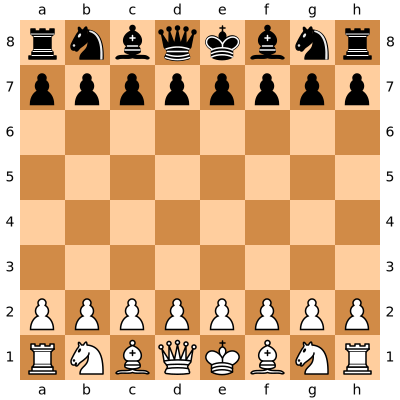

In [4]:
board

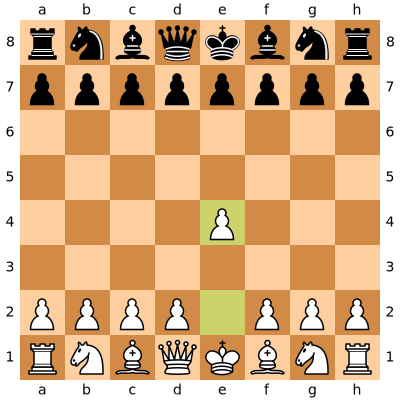

In [5]:
board.push(chess.Move.from_uci("e2e4"))
board

In [6]:
board.reset_board()

Pretty straightforward. Next we create a program that simulates random chess games where the moves are selected uniformly at random.

In [7]:
def simulate_game():
    
    def get_current_time():
        from datetime import datetime
        return datetime.strftime(datetime.now(), "%Y/%m/%d %H:%M:%S.%f")
    
    def initialise_game():
        game = chess.pgn.Game()
        board = game.board()
        game.headers['Date'] = get_current_time()
        game.headers['Black'] = 'Random Agent'
        game.headers['White'] = 'Random Agent'
        return game, board
    
    def get_next_move():
        from random import sample
        return sample(list(board.legal_moves), 1)[0]
        
    game, board = initialise_game()
    next_move = get_next_move()
    node = game.add_variation(next_move)
    board.push(next_move)
    while not board.is_game_over():
        next_move = get_next_move()
        node = node.add_variation(next_move)
        board.push(next_move)
    
    game.headers['Result'] = board.result()
    
    return game, board

[Event "?"]
[Site "?"]
[Date "2017/11/14 17:27:18.899187"]
[Round "?"]
[White "Random Agent"]
[Black "Random Agent"]
[Result "1/2-1/2"]

1. d4 h5 2. Kd2 Na6 3. c4 b6 4. Qa4 g5 5. Qd1 g4 6. Kc3 h4 7. e4 Nf6 8. Qe2 Rb8 9. b3 g3 10. Kc2 Bg7 11. d5 Nh7 12. Na3 c5 13. Qe3 Ra8 14. Bd2 b5 15. Ne2 Bc3 16. h3 gxf2 17. Qd4 f5 18. cxb5 Bb7 19. Kd3 Bxa1 20. Bb4 cxb4 21. Kc2 Nf6 22. Qxb4 Nxb4+ 23. Kc1 fxe4 24. Nf4 Ng4 25. Nb1 Qc7+ 26. Nc3 Qa5 27. Nb1 Qb6 28. Kd1 Qa6 29. g3 Rh6 30. Ke2 Bd4 31. bxa6 e3 32. axb7 Bb2 33. Nd2 Rc6 34. a4 Na2 35. b4 a6 36. Nh5 Nh6 37. a5 Ra7 38. Kxe3 Bc3 39. Kd3 hxg3 40. Ng7+ Kf8 41. Nf3 Rb6 42. b8=N Kxg7 43. Nh2 Re6 44. dxe6 Nf5 45. Ke2 Rc7 46. exd7 Ba1 47. d8=R Ne3 48. Kxe3 Kf6 49. Nc6 e6 50. Rd7 Kg6 51. Bxa6 Kh5 52. Re7 Rc8 53. Rc7 Rf8 54. Rf1 Bc3 55. Be2+ Kg5 56. Nf3+ Kh6 57. Re7 Rg8 58. Ne1 Bd2+ 59. Kd3 fxe1=B 60. a6 Bg5 61. Na5 Bh4 62. Rf5 Nc1+ 63. Ke4 Bc3 64. Ke3 Be5 65. Bb5 Bd6 66. Rf8 Rg7 67. Nb7 Bdxe7 68. Ba4 Rh7 69. Bd7 Nb3 70. Kf4 Nd2 71. Be8 Nb3 72. Kg4 Kg7 7

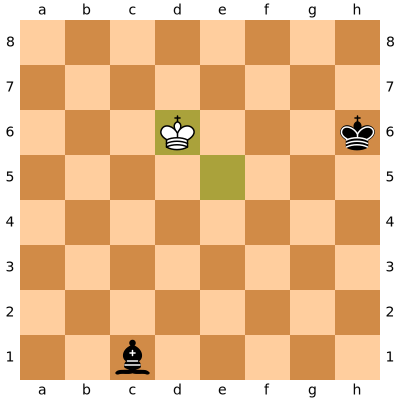

In [8]:
game, board = simulate_game()
print(game)
board

## Featurising Chess

Now that we can successfully simulate a random chess game, the next job is to turn the board position into a set of features that can be fed into a machine learning algorithm. In this part, I will take inspiration from the AlphaGo Zero model.

In [9]:
import numpy as np

We want to one-hot encode the positions of each piece on the board. As the package is written, board positions are stored using 64 bit integers. In order to repackage the board positions as a numpy array, we need to write a function to convert them.

In [10]:
def int_to_mask(squares):
    '''Takes a set of squares as an integer and returns an 8x8 matrix of the marked squares'''
    # convert int to binary
    squares = np.binary_repr(squares, width=64)
    # break int string into one-hot array
    squares = np.array([i for i in squares])
    # reshape into 8 by 8 matrix
    squares = squares.reshape(8,8)
    # flip along y axis (for some reason)
    squares = squares[:,::-1]
    # change type to int
    squares = squares.astype(np.int0)
    return squares

Now we can use `int_to_mask` to express where each piece on the board is as a numpy array.

In [11]:
int_to_mask(board.pieces_mask(color=chess.BLACK, piece_type=chess.KING))

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

We compare our result with the board below.

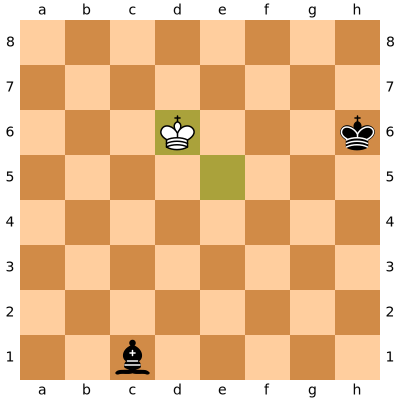

In [12]:
board

## Featurising the board position

In order to create features for the deep learning model, we will arrange the board position as a stack of `8 x 8` arrays. We will create one-hot encoded layers for each unique piece type and colour. The order of the first 12 layers will be as follows:

- White Pawn
- White Knight
- White Bishop
- White Rook
- White Queen
- White King

- Black Pawn
- Black Knight
- Black Bishop
- Black Rook
- Black Queen
- Black King

We can repeat this stack 4 times to store the past few moves on the board. This will be necessary to give the model the ability to detect 'En Passant'.

We will also add one more layer to indicate which rooks on the board are still capable of castling. And one last layer to indicate if it is the white player's turn.

That makes `12 x 4 + 2 = 50` layers over all, totalling `3200` input values.

## Building the Feature Matrix

Now I'll write the code to build the first `14` layers of the model from the game board.

In [13]:
input_data = np.zeros(shape = (14, 8, 8))
for i, colour in enumerate(chess.COLORS):
    for j, piece in enumerate(chess.PIECE_TYPES):
        k = i * len(chess.PIECE_TYPES) + j
        input_data[k, :, :] = int_to_mask(board.pieces_mask(color=colour, piece_type=piece))
        print(input_data[k, :, :])
        print()

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 

Next we add the castling information:

In [14]:
input_data[k + 1, :, :] = int_to_mask(board.castling_rights)
input_data[k + 1, :, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

And lastly whose turn it is.

In [15]:
input_data[k + 2, :, :] = board.turn * np.ones((8, 8))
input_data[k + 2, :, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Now we package these operations into a function that can generate the feature matrix for a given board.

In [16]:
def featurise_board(board):
    board_data = np.zeros(shape = (12, 8, 8))
    for i, colour in enumerate(chess.COLORS):
        for j, piece in enumerate(chess.PIECE_TYPES):
            k = i * len(chess.PIECE_TYPES) + j
            piece_location = board.pieces_mask(color=colour, piece_type=piece)
            board_data[k, :, :] = int_to_mask(piece_location)
    return board_data

## Defining the Foward Pass

Now that we have a sensible feature set, we have to create a model architecture, and then perform a forward pass with a random initialisation to make sure that the model output is well defined. Ideally, we would like to implement a Deep Residual Network. 

Once we have that, we will be able to start working on the Markov Chain Monte Carlo (MCMC) Tree Search implementation, and also the training loop for the model.

Some useful resources:
- https://codesachin.wordpress.com/2017/02/19/residual-neural-networks-as-ensembles/
- https://blog.waya.ai/deep-residual-learning-9610bb62c355

## What is a Move?

Before we can define the forward pass, we have define our target output. We want the model to map board positions to moves on the board, so we need a way to express what a particular move on the board looks like to the neural network.

All moves in chess are performed by selecting a piece, and moving it to a new square. At the same time that a piece is moved, there can be side-effects on the board (e.g. a piece capture, or another piece may move as in castling). This means that the target output can simply be a selection of a piece in one location, along with the target location where the piece has been moved.

This means we can represent moves via an `64 x 64 = 4096` array where moves are given as ordered pairs of squares on the board (i.e. a 'from' square to select the piece on that square and a 'target' square to select where the piece is moving).

However, we also need to add 4 more output parameters as well to describe pawn promotion. This is because when a pawn promotes to the other side of the board, the model will need to select which piece (Queen, Rook, Bishop or Knight) the AI will choose to replace the pawn. This makes for `5000` output parameters, which is quite a lot more than I would have expected.

If I can think of ways to simplify the output parameter space later, then I will. This large search space strikes me as unparsimonious.

## Coding Move Selection

Here I'll be writing the code that constructs a representation of each possible move on the board. The trick here is to do this based on the `uci` for each move.

In [17]:
# initialise the target values
move_data = np.zeros((8, 8, 8, 8))
move_data.shape

(8, 8, 8, 8)

In [18]:
def uci_to_matrix(uci):
    move_data = np.zeros((8, 8, 8, 8))
    letters = dict(zip('abcdefgh', range(8)))
    i, j, k, l = [letters[ch] if ch in letters else int(ch) for ch in uci]
    move_data[i, j, k, l] = 1
    return move_data

There is still the question of how to represent pawn promotion. In order to find out how `move.uci()` does it, I'll create a fresh board and promote a pawn in order to find out what happens.

In [19]:
board.clear_board()
board.set_piece_at(square = chess.H2, piece = chess.Piece(chess.PAWN, chess.BLACK))
legal_moves = list(board.legal_moves)
legal_moves

[Move.from_uci('h2h1q'),
 Move.from_uci('h2h1r'),
 Move.from_uci('h2h1b'),
 Move.from_uci('h2h1n')]

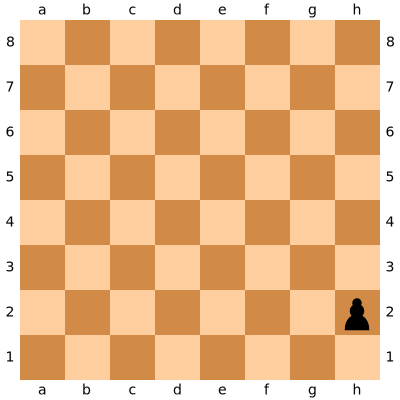

In [20]:
board

This shows us how `uci` represents pawn promotion. So all we have to do is modify the `uci_to_matrix` function to make sure this is represented as well.

In [23]:
def uci_to_array(uci):
    move_data = np.zeros((8, 8, 8, 8))
    prom_data = np.zeros(4)
    
    if len(uci) == 5:
        # handle pawn promotion
        prom_dict = dict(zip('qrbn', range(4)))
        prom_piece = prom_dict[uci[-1]]
        prom_data[prom_piece] = 1
        uci = uci[:-1]
    
    # record piece movement
    letters = dict(zip('abcdefgh', range(8)))
    i, j, k, l = [letters[ch] if ch in letters else int(ch) for ch in uci]
    print(i, j, k, l)
    move_data[i, j, k, l] = 1
    
    return move_data, prom_data

In [24]:
move_uci = legal_moves[0].uci()
move_data, prom_data = uci_to_array(move_uci)
move_uci

7 2 7 1


'h2h1q'

In [25]:
prom_data

array([ 1.,  0.,  0.,  0.])

In [26]:
for i, j in it.product(range(8), range(8)):
    data = move_data[i, j, :, :]
    if np.sum(data) == 1:
        print(i, j)
        print(data)

7 2
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]]


In [27]:
for i, j in it.product(range(8), range(8)):
    data = move_data[:, :, i, j]
    if np.sum(data) == 1:
        print(i, j)
        print(data)

7 1
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]]


We also need to create the inverse map as well:

In [70]:
def array_to_uci(move_data, prom_data):
    i, j, k, l = np.transpose(np.nonzero(move_data))[0]
    letters = dict(zip(range(8), 'abcdefgh'))
    prom_dict = dict(zip(range(4), 'qrbn'))
    prom_piece = prom_dict[np.argmax(prom_data)]
    return letters[i] + str(j) + letters[k] + str(l) + prom_piece

In [71]:
array_to_uci(move_data, prom_data), move_uci

('h2h1q', 'h2h1q')

It works!

## Defining the Network Architecture

Now that we've gotten this far, it's time to have a go at creating an architecture that creates the output that we need in order to run the model.

In [72]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [ ]:
import tensorflo

Here the idea is to follow the DeepMind paper closely (but with a smaller network overall). The AlphaGo Zero model consists of a single convolutional block followed by a sequence of residual blocks.

The convolutional block applies the following modules:
- A convolution of `256` filters of kernel size `3 × 3` with stride `1`
- Batch normalization
- A rectifier nonlinearity

Each residual block applies the following modules sequentially to its input:
- A convolution of `256` filters of kernel size `3 × 3` with stride `1`
- Batch normalization
- A rectifier nonlinearity
- A convolution of `256` filters of kernel size `3 × 3` with stride `1`
- Batch normalization
- A skip connection that adds the input to the block
- A rectifier nonlinearity

In [ ]:
from tf. import layers

def convolutional_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)


def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = layers.Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    y = layers.add([shortcut, y])
    y = layers.LeakyReLU()(y)

    return y